<a href="https://colab.research.google.com/github/Alro10/PyTorch1.0Tutorials/blob/master/lesson02-regression/02_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Linear Regression

In this tutorial, we will take a look and implement the classic linear regression algorithm 

$$y = a + bx + \varepsilon$$

Linear Regression involves creating a best fit linear line such the distance between the y' points on line and real values is minimum (the summation of the distance is known as our loss)

## Gradient Descent

### Step 1: Compute the loss

$$MSE = \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2 $$

$$MSE = \frac{1}{N} \sum_{i=1}^N (y_i - a - bx_i )^2 $$

<h4><center>Mean Square Error (MSE)</center></h4>


### Step 2: Compute the gradients

\begin{equation}
\frac{\partial MSE}{\partial a} = \frac{\partial MSE}{\partial \hat{y}_i} \frac{\partial  \hat{y}_i}{\partial a}  = \frac{1}{N} \sum_{i=1}^N 2(y_i  - a - bx_i) (-1) = -2\frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)
\end{equation}


\begin{equation}
\frac{\partial MSE}{\partial a} = \frac{\partial MSE}{\partial \hat{y}_i} \frac{\partial  \hat{y}_i}{\partial a}  = \frac{1}{N} \sum_{i=1}^N 2(y_i  - a - bx_i) (-1) (x_i)= -2\frac{1}{N} \sum_{i=1}^N x_i(y_i - \hat{y}_i)
\end{equation}

<h4><center>Computing gradients w.r.t. parameters</center></h4>

### Step 3: Update the parameters

\begin{equation}
a = a - \alpha \frac{\partial MSE}{\partial a} 
\end{equation}

\begin{equation}
b = b - \alpha \frac{\partial MSE}{\partial b} 
\end{equation}

##Data generation

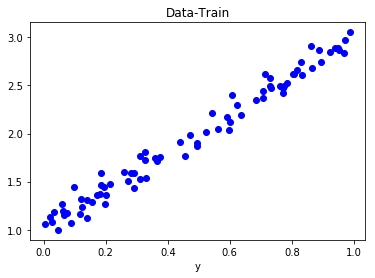

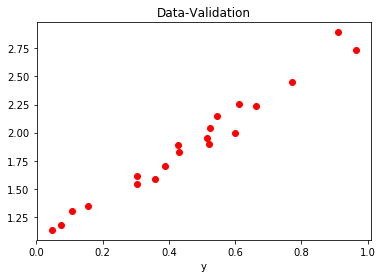

In [2]:
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline


# Data Generation
np.random.seed(42)
x = np.random.rand(100, 1)
y = 1 + 2 * x + .1 * np.random.randn(100, 1)

# Shuffles the indices
idx = np.arange(100)
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses the remaining indices for validation
val_idx = idx[80:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

plt.plot(x_train, y_train, 'bo')
plt.title('Data-Train')
plt.xlabel('x')
plt.xlabel('y')
plt.show()

plt.plot(x_val, y_val, 'ro')
plt.title('Data-Validation')
plt.xlabel('x')
plt.xlabel('y')
plt.show()


## Numpy

In [3]:
# Initializes parameters "a" and "b" randomly
np.random.seed(42)
a = np.random.randn(1)
b = np.random.randn(1)

print(' a and b after initialization')
print(a, b)

# Sets learning rate
lr = 1e-1
# Defines number of epochs
n_epochs = 1000

for epoch in range(n_epochs):
    # Computes our model's predicted output
    yhat = a + b * x_train
    
    # How wrong is our model? That's the error! 
    error = (y_train - yhat)
    # It is a regression, so it computes mean squared error (MSE)
    loss = (error ** 2).mean()
    
    # Computes gradients for both "a" and "b" parameters
    a_grad = -2 * error.mean()
    b_grad = -2 * (x_train * error).mean()
    
    # Updates parameters using gradients and the learning rate
    a = a - lr * a_grad
    b = b - lr * b_grad

print(' a and b after gradient descent')    
print(a, b)

# Sanity Check: do we get the same results as our gradient descent?
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(x_train, y_train)
print(' a and b by scikit-learn')
print(linr.intercept_, linr.coef_[0])

 a and b after initialization
[0.49671415] [-0.1382643]
 a and b after gradient descent
[1.02354094] [1.96896411]
 a and b by scikit-learn
[1.02354075] [1.96896447]


## Pytorch!

In [9]:
!pip install torchviz  # package for dynamic computation Graph

     |████████████████████████████████| 51kB 4.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [10]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot

print(torch.__version__)
torch.cuda.is_available()

1.1.0


True

###Loading Data, Devices and CUDA

In [11]:
# switch to False to use CPU
use_cuda = True

use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");


# Our data was in Numpy arrays, but we need to transform them into PyTorch's Tensors
# and then we send them to the chosen device
x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

# Here we can see the difference - notice that .type() is more useful
# since it also tells us WHERE the tensor is (device)
print(type(x_train), type(x_train_tensor), x_train_tensor.type())

<class 'numpy.ndarray'> <class 'torch.Tensor'> torch.cuda.FloatTensor


In [12]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

print(' a and b after initialization')
print(a, b)

lr = 1e-1
n_epochs = 1000

# Defines a SGD optimizer to update the parameters
optimizer = optim([a, b], lr=lr)

for epoch in range(n_epochs):
    yhat = a + b * x_train_tensor
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    loss.backward()    
    
    # No more manual update!
    # with torch.no_grad():
    #     a -= lr * a.grad
    #     b -= lr * b.grad
    optimizer.step()
    
    # No more telling PyTorch to let gradients go!
    # a.grad.zero_()
    # b.grad.zero_()
    optimizer.zero_grad()
    
print(' a and b after gradient descent using Pytorch') 
print(a, b)

 a and b after initialization
tensor([0.6226], device='cuda:0', requires_grad=True) tensor([1.4505], device='cuda:0', requires_grad=True)
 a and b after gradient descent using Pytorch
tensor([1.0235], device='cuda:0', requires_grad=True) tensor([1.9690], device='cuda:0', requires_grad=True)


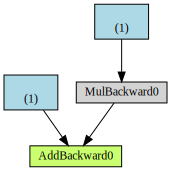

In [13]:
torch.manual_seed(42)
a = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

yhat = a + b * x_train_tensor
error = y_train_tensor - yhat
loss = (error ** 2).mean()

make_dot(yhat)
